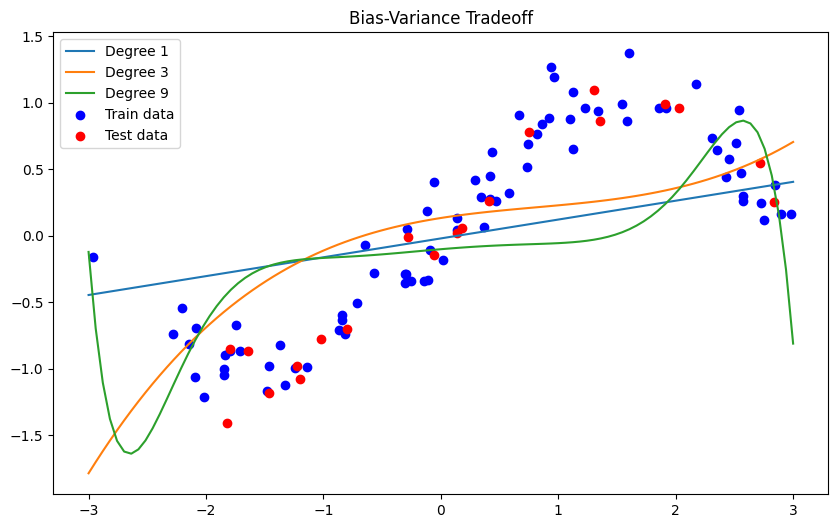

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Generate synthetic data
def generate_data(n_samples=100, noise=0.1):
    X = np.random.uniform(-3, 3, size=(n_samples, 1))
    y = np.sin(X) + noise * np.random.randn(n_samples, 1)
    return X, y

# Polynomial regression model class
class PolynomialRegression(nn.Module):
    def __init__(self, degree):
        super(PolynomialRegression, self).__init__()
        self.poly = PolynomialFeatures(degree)
        self.linear = nn.Linear(degree + 1, 1, bias=True)

    def forward(self, X):
        poly_X = self.poly.fit_transform(X.cpu().numpy())
        poly_X_tensor = torch.tensor(poly_X, dtype=torch.float32, device=X.device)
        return self.linear(poly_X_tensor)

# Train the model
def train_model(X_train, y_train, model, optimizer, criterion, epochs=1000, device="cpu"):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        if torch.isnan(loss):
            print(f"NaN loss encountered at epoch {epoch}. Stopping training.")
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
    return model

# Plot results
def plot_results(X_train, y_train, X_test, y_test, models, degrees, scaler_X, scaler_y, device="cpu"):
    plt.figure(figsize=(10, 6))
    X_plot = np.linspace(-3, 3, 100).reshape(-1, 1)
    X_plot_scaled = scaler_X.transform(X_plot)  # Scale X_plot using the same scaler

    for degree, model in zip(degrees, models):
        with torch.no_grad():
            X_plot_tensor = torch.tensor(X_plot_scaled, dtype=torch.float32, device=device)
            predictions = model(X_plot_tensor).cpu().numpy()
            predictions = scaler_y.inverse_transform(predictions)  # Inverse transform predictions
        plt.plot(X_plot, predictions, label=f'Degree {degree}')

    plt.scatter(scaler_X.inverse_transform(X_train), scaler_y.inverse_transform(y_train), color='blue', label='Train data')
    plt.scatter(scaler_X.inverse_transform(X_test), scaler_y.inverse_transform(y_test), color='red', label='Test data')
    plt.legend()
    plt.title('Bias-Variance Tradeoff')
    plt.show()

# Main script
if __name__ == "__main__":
    # Check for GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Generate data
    X, y = generate_data(n_samples=100, noise=0.2)

    # Normalize data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Degrees of polynomials to evaluate
    degrees = [1, 3, 9]

    # Train models and evaluate
    models = []
    for degree in degrees:
        model = PolynomialRegression(degree).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4)  # Lower learning rate and weight decay
        criterion = nn.MSELoss()
        model = train_model(X_train, y_train, model, optimizer, criterion, device=device)
        models.append(model)

    # Plot results
    plot_results(X_train, y_train, X_test, y_test, models, degrees, scaler_X, scaler_y, device=device)


